## Define model architecture

In [1]:
import torch
import torch.nn as nn
from einops import rearrange, repeat

class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size."
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = channels * patch_size * patch_size

        self.proj = nn.Linear(self.patch_dim, dim)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = rearrange(x, "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_size, p2=patch_size)
        x = self.proj(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.fc = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, num_patches, dim = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        queries, keys, values = map(
            lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), qkv
        )

        scores = torch.einsum("bhqd, bhkd -> bhqk", queries, keys) * self.scale
        attention = scores.softmax(dim=-1)
        attention = self.dropout(attention)

        out = torch.einsum("bhqk, bhvd -> bhqd", attention, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.fc(out)
        return out

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(dim, heads, dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, dim, channels)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, (image_size // patch_size) ** 2 + 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer = nn.ModuleList([
            TransformerEncoderBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b=batch_size)
        x = torch.cat([cls_tokens, x], dim=1)

        x += self.pos_embedding
        x = self.dropout(x)

        for layer in self.transformer:
            x = layer(x)

        x = self.norm(x[:, 0])
        x = self.head(x)
        return x


## Load datasets

In [2]:
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms


torch.manual_seed(42)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# use 10% of datasets

train_indices, _, train_labels, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.9,
    random_state=42
)

test_indices, _, test_labels, _ = train_test_split(
    range(len(test_dataset)),
    test_dataset.targets,
    stratify=test_dataset.targets,
    test_size=0.9,
    random_state=42
)

reduced_train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
reduced_test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

batch_size = 64

# Data loaders
train_loader = torch.utils.data.DataLoader(reduced_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(reduced_test_dataset, batch_size=batch_size, shuffle=False)

# Verify proportions
print("Train dataset label proportions:", torch.bincount(torch.tensor(train_labels)) / len(train_labels))
print("Test dataset label proportions:", torch.bincount(torch.tensor(test_labels)) / len(test_labels))


100%|██████████| 170M/170M [00:03<00:00, 55.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train dataset label proportions: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
Test dataset label proportions: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


In [3]:
len(train_loader), len(test_loader), len(reduced_train_dataset), len(reduced_test_dataset)

(79, 16, 5000, 1000)

## Initialise model

In [4]:
import torch.optim as optim

# Define model parameters

image_size = 32
patch_size = 4
num_classes = 10
dim = 128
depth = 6
heads = 8
mlp_dim = 256
dropout = 0.1
epochs = 30


model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    channels=3,
    dropout=dropout
)

device = torch.device("cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

### Training loop

In [5]:
for epoch in range(epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}")

Epoch [1/30] Batch 0/79 Loss: 2.3682
Epoch [1/30] Batch 50/79 Loss: 2.4043
Epoch [2/30] Batch 0/79 Loss: 2.2945
Epoch [2/30] Batch 50/79 Loss: 2.3342
Epoch [3/30] Batch 0/79 Loss: 2.0782
Epoch [3/30] Batch 50/79 Loss: 2.1917
Epoch [4/30] Batch 0/79 Loss: 2.1005
Epoch [4/30] Batch 50/79 Loss: 2.0987
Epoch [5/30] Batch 0/79 Loss: 2.2769
Epoch [6/30] Batch 0/79 Loss: 2.0761
Epoch [6/30] Batch 50/79 Loss: 2.2655
Epoch [7/30] Batch 0/79 Loss: 2.0548
Epoch [7/30] Batch 50/79 Loss: 2.0899
Epoch [8/30] Batch 0/79 Loss: 2.0809
Epoch [8/30] Batch 50/79 Loss: 2.0181
Epoch [9/30] Batch 0/79 Loss: 2.1236
Epoch [9/30] Batch 50/79 Loss: 2.2484
Epoch [10/30] Batch 0/79 Loss: 2.1304
Epoch [10/30] Batch 50/79 Loss: 2.0626
Epoch [11/30] Batch 0/79 Loss: 2.0181
Epoch [11/30] Batch 50/79 Loss: 2.2638
Epoch [12/30] Batch 0/79 Loss: 1.9785
Epoch [12/30] Batch 50/79 Loss: 2.1025
Epoch [13/30] Batch 0/79 Loss: 2.2028
Epoch [13/30] Batch 50/79 Loss: 2.0470
Epoch [14/30] Batch 0/79 Loss: 1.9804
Epoch [14/30] Bat

### Histogram of labels

In [6]:
train_labels = [reduced_train_dataset[idx][1] for idx in range(len(reduced_train_dataset))]
print("Training Dataset Labels:", train_labels)

test_labels = [reduced_test_dataset[idx][1] for idx in range(len(reduced_test_dataset))]
print("Testing Dataset Labels:", test_labels)

from collections import Counter
print("Training Label Counts:", Counter(train_labels))
print("Testing Label Counts:", Counter(test_labels))


Training Dataset Labels: [4, 7, 7, 3, 7, 1, 2, 1, 8, 1, 5, 3, 2, 0, 7, 1, 9, 9, 0, 3, 6, 4, 4, 4, 4, 9, 6, 6, 4, 5, 7, 6, 3, 8, 3, 7, 7, 8, 1, 0, 3, 9, 3, 7, 2, 9, 0, 8, 9, 4, 9, 9, 5, 1, 7, 8, 6, 2, 7, 4, 0, 2, 3, 6, 1, 7, 8, 7, 7, 9, 6, 4, 2, 3, 0, 7, 1, 5, 0, 8, 6, 8, 3, 5, 6, 5, 8, 2, 1, 6, 6, 5, 6, 2, 7, 9, 9, 4, 1, 7, 0, 7, 9, 4, 2, 0, 8, 4, 6, 7, 1, 0, 8, 0, 6, 1, 5, 7, 5, 4, 6, 5, 0, 8, 2, 3, 8, 1, 8, 7, 4, 3, 0, 1, 0, 2, 5, 4, 7, 0, 9, 6, 0, 9, 5, 1, 0, 3, 7, 6, 4, 7, 4, 6, 4, 6, 3, 0, 9, 2, 5, 7, 6, 7, 3, 0, 8, 6, 9, 3, 4, 3, 8, 1, 8, 6, 8, 3, 1, 1, 5, 7, 5, 8, 2, 5, 3, 7, 7, 8, 7, 0, 4, 4, 6, 7, 4, 1, 0, 2, 8, 1, 7, 5, 5, 4, 6, 1, 6, 1, 1, 3, 7, 7, 8, 1, 5, 7, 5, 0, 9, 6, 6, 1, 3, 8, 6, 3, 6, 9, 9, 0, 2, 2, 1, 7, 9, 5, 4, 9, 9, 3, 3, 6, 6, 5, 8, 0, 2, 4, 0, 7, 5, 2, 7, 1, 1, 5, 4, 2, 4, 0, 0, 4, 9, 2, 4, 0, 1, 6, 1, 8, 7, 2, 2, 2, 7, 5, 4, 4, 1, 2, 3, 9, 4, 4, 1, 1, 3, 6, 2, 1, 1, 7, 2, 3, 0, 7, 7, 5, 9, 7, 8, 6, 8, 5, 8, 0, 2, 3, 2, 8, 3, 4, 1, 8, 7, 8, 4, 7, 2, 0, 2, 9, 3,

In [7]:
label_names = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

train_labels_named = [label_names[reduced_train_dataset[idx][1]] for idx in range(len(reduced_train_dataset))]
print("Training Dataset Labels (Named):", set(train_labels_named))

# Print labels with their names
test_labels_named = [label_names[reduced_test_dataset[idx][1]] for idx in range(len(reduced_test_dataset))]
print("Testing Dataset Labels (Named):", set(test_labels_named))


Training Dataset Labels (Named): {'Deer', 'Frog', 'Dog', 'Automobile', 'Ship', 'Horse', 'Airplane', 'Bird', 'Cat', 'Truck'}
Testing Dataset Labels (Named): {'Deer', 'Frog', 'Dog', 'Automobile', 'Ship', 'Horse', 'Airplane', 'Bird', 'Cat', 'Truck'}


### Evaluaion of model on test set

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


all_targets = []
all_predictions = []

correct = 0
total = 0

model.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy of the model on the {len(reduced_test_dataset)} test images: {100 * correct / total}%')

Accuracy of the model on the 1000 test images: 25.9%


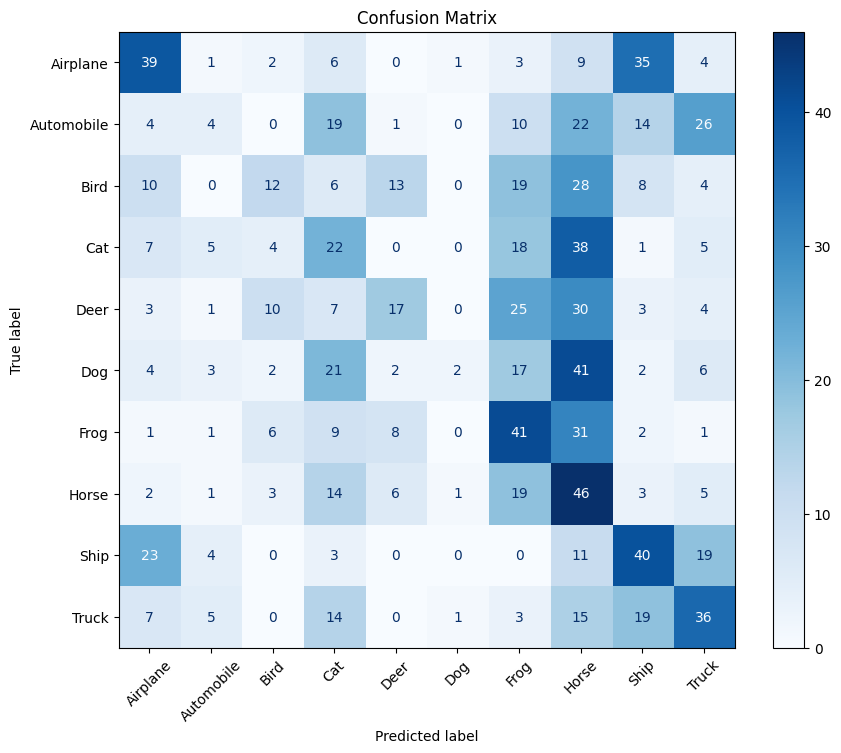

In [12]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[label_names[i] for i in range(10)])
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()